<a href="https://colab.research.google.com/github/muhammetsnts/SPARK_NLP/blob/master/projects/1.Symptom_Disease_and_Treatment_Analysis_on_Oncological_Texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symptom and Treatment Analysis on Oncological Texts

In this study, we will try to find the most common symptoms of oncological diseases and which type of treatments are applied to them.

We will use [MT ONCOLOGY NOTES](https://www.mtsamplereports.com/) as sample oncological clinic texts. [John Snow Labs](https://github.com/JohnSnowLabs/spark-nlp-workshop) has already provides this dataset in their workshop repo.

We will follow these stages:



*   Setup Environment and Installations
*   Download Dataset
*   Create NER Pipeline
*   Detection of the Most Common Treatments in Oncological Diseases
*   Detection of the Most Common Symptoms in Oncological Diseases
*   Extraction of the Most Common Oncological Diseases
*   Extract the Most Frequent Oncological Disease and Symptom Pairs Based on Documents







## Setup Environment

In [2]:
!pip install --upgrade plotly

**You need to restart runtime.**

Loading JSL license.

In [ ]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# key-value çiftinin local değişkenler olarak tanımlanması
locals().update(license_keys)

# key-value çiftinin ortam değişkenleri olarak tanımlanması
import os
os.environ.update(license_keys)

Installing Spark NLP and PySpark.

In [3]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

Start Spark Session

In [4]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 3.3.4
Spark NLP_JSL Version : 3.3.4


## Download Dataset

In [5]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/mt_samples.csv

**Read the dataset as Spark dataframe.**

In [6]:
mt_samples_df = spark.createDataFrame(pd.read_csv("mt_samples.csv").reset_index())

In [7]:
mt_samples_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)



We have 50 oncological sample notes.

In [8]:
print("Lenght of the dataframe :", mt_samples_df.count(), "\n")

mt_samples_df.show()

Lenght of the dataframe : 50 

+-----+--------------------+
|index|                text|
+-----+--------------------+
|    0|Sample Type / Med...|
|    1|Sample Type / Med...|
|    2|Sample Type / Med...|
|    3|Sample Type / Med...|
|    4|Sample Type / Med...|
|    5|Sample Type / Med...|
|    6|Sample Type / Med...|
|    7|Sample Type / Med...|
|    8|Sample Type / Med...|
|    9|Sample Type / Med...|
|   10|Sample Type / Med...|
|   11|Sample Type / Med...|
|   12|Sample Type / Med...|
|   13|Sample Type / Med...|
|   14|Sample Type / Med...|
|   15|Sample Type / Med...|
|   16|Sample Type / Med...|
|   17|Sample Type / Med...|
|   18|Sample Type / Med...|
|   19|Sample Type / Med...|
+-----+--------------------+
only showing top 20 rows



Lets print one and see how it looks like.

In [9]:
sample_text = mt_samples_df.limit(1).collect()[0]['text']

print(sample_text)

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care cen

## NER Pipeline

Lets start with the base stages of our pipeline. We will use word embeddings for vectorizing our tokens.

In [10]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
  .setInputCols(["document"]) \
  .setOutputCol("sentence")

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


Now we will instal `ner_bionlp` model for its `Cancer` entities and `ner_jsl` for its `Oncological`, `Symptom` and `Treatment` entities.

In [11]:
# Cancer
bionlp_ner = MedicalNerModel.pretrained("ner_bionlp", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("bionlp_ner")\
  .setBatchSize(128)\
  .setIncludeConfidence(False)

bionlp_ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "bionlp_ner"]) \
  .setOutputCol("bionlp_ner_chunk")\
  .setWhiteList(["Cancer"])

# Clinical Terminology
jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("jsl_ner")\
  .setBatchSize(128)\
  .setIncludeConfidence(False)

jsl_ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "jsl_ner"]) \
  .setOutputCol("jsl_ner_chunk")\
  .setWhiteList(["Oncological", "Symptom", "Treatment"])

ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14.5 MB
[OK!]


We used two different NER models and we will merge their results by using `ChunkMergeApproach` annotator. But we will convert `Cancer` labels to `Oncological` while merging for making a better analysis.

In [12]:
replace_dict = 'Cancer,Oncological'

with open("replace_dict.csv", "w") as f:
  f.write(replace_dict)

In [13]:
chunk_merger = ChunkMergeApproach()\
  .setInputCols("bionlp_ner_chunk","jsl_ner_chunk")\
  .setOutputCol("final_ner_chunk")\
  .setReplaceDictResource('replace_dict.csv',"text", {"delimiter":","})

It's time to create NER pipeline.

In [14]:
ner_pipeline= Pipeline(stages = [
                            documentAssembler,
                            sentenceDetector,
                            tokenizer,
                            word_embeddings,          
                            bionlp_ner,
                            bionlp_ner_converter,
                            jsl_ner,
                            jsl_ner_converter,
                            chunk_merger]
)

ner_model = ner_pipeline.fit(spark.createDataFrame([['']]).toDF("text"))

Now we can transform our data by using our `ner_model`.

In [16]:
%%time
ner_res = ner_model.transform(mt_samples_df)

# ner_res.repartition(12).write.format("parquet").save("ner_result.parquet")

CPU times: user 85.6 ms, sys: 8.45 ms, total: 94.1 ms
Wall time: 947 ms


### Visualization of the Results

We can visualize the results with `sparknlp_display` library of Spark NLP. For using this library, we should get the results by LightPipeline. LightPipeline is a special pipeline for getting results faster from shorter texts.

In [17]:
light_model =  LightPipeline(ner_model)
ann_text = light_model.fullAnnotate(sample_text)[0]

ann_text.keys()

dict_keys(['document', 'final_ner_chunk', 'jsl_ner_chunk', 'bionlp_ner', 'jsl_ner', 'token', 'embeddings', 'sentence', 'bionlp_ner_chunk'])

In [18]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'ONCOLOGICAL':'#ff2e51', 'TREATMENT': '#3bdeff', 'SYMPTOM': '#FFC300' })

visualiser.display(ann_text, label_col='final_ner_chunk')

We can convert our results to pandas dataframe.

In [19]:
%%time

ner_pdf = ner_res.select("index", F.explode(F.arrays_zip('final_ner_chunk.result', 
                                                       'final_ner_chunk.metadata')).alias("cols"))\
                 .select("index", F.expr("cols['0']").alias("final_chunk"), 
                                 F.expr("cols['1']['entity']").alias("entity")).toPandas()

CPU times: user 428 ms, sys: 45.2 ms, total: 473 ms
Wall time: 1min 4s


In [20]:
ner_pdf.head(40)

,index,final_chunk,entity
0,0,Mesothelioma,Oncological
1,0,Mesothelioma,Oncological
2,0,Mesothelioma,Oncological
3,0,cough,Symptom
4,0,chest pain,Symptom
5,0,cough,Symptom
6,0,chest pain,Symptom
7,0,cancer,Oncological
8,0,numbness,Symptom
9,0,tingling of her left arm,Symptom


Lets show the label counts.

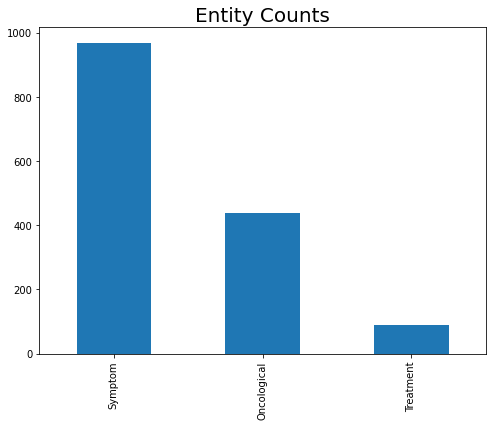

In [21]:
ner_pdf.entity.value_counts().plot(kind="bar", figsize=(8,6))
plt.title("Entity Counts", fontdict={"fontsize":20})

plt.show()

## Detection of the Most Common Treatments in Oncological Diseases

Now we can look for the `Treatments` applied to patients have oncological disease.

In [ ]:
treatment_df = ner_pdf[ner_pdf.entity=="Treatment"]
treatment_df.rename(columns={"final_chunk":"treatment"}, inplace=True)
treatment_df.treatment = treatment_df.treatment.str.lower()

treatment_df.treatment.value_counts().head(20)

chemotherapy                             34
transfusion                               7
brachytherapy                             5
radiotherapy                              5
intensity-modulated radiation therapy     3
hdr brachytherapy                         3
prostate brachytherapy                    3
breast radiation therapy                  2
pelvic radiation                          2
chop chemotherapy                         2
radiation therapy                         2
chemoradiotherapy                         2
transfused                                2
radiation                                 2
breast conservation therapy               1
adjuvant chemotherapy                     1
platelet transfusion                      1
blood transfusion                         1
electron beam radiotherapy                1
hormonal therapy                          1
Name: treatment, dtype: int64

We will manuplate the data by changing `radiation` term to `radiation threapy`.

In [ ]:
 treatment_df.treatment = treatment_df.treatment.replace({"radiation":"radiation therapy"})
 treatment_df.treatment.value_counts().head(20)

chemotherapy                             34
transfusion                               7
brachytherapy                             5
radiotherapy                              5
radiation therapy                         4
hdr brachytherapy                         3
intensity-modulated radiation therapy     3
prostate brachytherapy                    3
breast radiation therapy                  2
chop chemotherapy                         2
chemoradiotherapy                         2
transfused                                2
pelvic radiation                          2
physical therapy                          1
adjuvant chemotherapy                     1
platelet transfusion                      1
blood transfusion                         1
radiotherapy treatment                    1
electron beam radiotherapy                1
palliative radiation                      1
Name: treatment, dtype: int64

In [ ]:
treatment_df.shape

(90, 3)

In [ ]:
unique_treatment_df = treatment_df.groupby(["index","treatment"]).count().reset_index()[["index","treatment"]]
unique_treatment_df.shape

(45, 2)

We can plot the mst common treatments applied to patients have oncological disease.

In [ ]:
data=unique_treatment_df.treatment.value_counts().head(20)
data_pdf=pd.DataFrame({"Count":data.values,'Treatment Entities':data.index})
fig = px.bar(data_pdf, y='Treatment Entities', x='Count',orientation='h',color='Count', 
             color_continuous_scale=px.colors.sequential.Oryel, width=1200, height=700) 

fig.update_layout(
    title={
        'text': "Most Common Treatment Entities",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center'
        },
  font=dict(size=15))

fig.show()

Chemotherapy is the most common treatment applied to oncological diseases. 

## Detection of the Most Common Symptoms in Oncological Diseases

Lets get the most common symptoms in our oncological texts.

In [22]:
symptom_df = ner_pdf[ner_pdf.entity=="Symptom"]
symptom_df.rename(columns={"final_chunk":"symptom"}, inplace=True)
symptom_df.final_chunk = symptom_df.symptom.str.lower()

symptom_df.symptom.value_counts().head(20)

mass                   36
pain                   20
edema                  19
lymphadenopathy        17
distress               16
cough                  14
night sweats           14
nausea                 14
murmurs                14
shortness of breath    13
hepatosplenomegaly     13
chest pain             12
chills                 11
lesion                 11
vomiting               11
fatigue                11
wound                   9
headaches               9
bleeding                9
masses                  9
Name: symptom, dtype: int64

As you can see, mass and masses are detected as different entities. So we can merge their counts for a fair analysis.

In [23]:
symptom_df.symptom = symptom_df.symptom.replace({"masses":"mass"})
symptom_df.symptom.value_counts().head(20)

mass                   45
pain                   20
edema                  19
lymphadenopathy        17
distress               16
murmurs                14
nausea                 14
night sweats           14
cough                  14
shortness of breath    13
hepatosplenomegaly     13
chest pain             12
chills                 11
vomiting               11
fatigue                11
lesion                 11
headaches               9
bleeding                9
wound                   9
diarrhea                8
Name: symptom, dtype: int64

In [24]:
symptom_df.shape

(968, 3)

We got the symptoms but we have a problem here. If a symptom exists more than one time in a clinical text, this will break our results. So we will get the unique symptom entities per document.

In [25]:
unique_symptom_df = symptom_df.groupby(["index","symptom"]).count().reset_index()[["index","symptom"]]
unique_symptom_df.shape

(805, 2)

Plotting Symptoms in Oncological Texts.

In [27]:
import plotly.express as px

data=unique_symptom_df.symptom.value_counts().head(20)
data_pdf=pd.DataFrame({"Count":data.values,'Symptom':data.index})
fig = px.bar(data_pdf, y='Symptom', x='Count',orientation='h',color='Count', 
             color_continuous_scale=px.colors.sequential.Bluered, width=1200, height=700) 

fig.update_layout(
    title={
        'text': "Most Common Symptom Entities",
        'y':0.95,
        'x':0.6,
        'xanchor': 'center'
        },
  font=dict(size=15))

fig.show()

As you can see from the graph, `edema` is detected as the most common symptom in these oncological texts. By the way, `mass` and `pain` counts were higher than `edema` before dropping duplicates in documents.

## Extraction of the Most Common Oncological Diseases

Now we will create an oncological_df from oncological entitiesa and drop duplicates in documents as we did for symptom entities.

In [28]:
oncological_df = ner_pdf[ner_pdf.entity=="Oncological"]
oncological_df.rename(columns={"final_chunk":"oncological"}, inplace=True)

oncological_df.oncological = oncological_df.oncological.str.lower()


oncological_df.oncological.value_counts().head(20)

basal cell carcinoma            26
breast cancer                   17
tumor                           17
parathyroid adenoma             12
cancer                          11
mesothelioma                    11
carcinoma                       11
breast                          10
colon cancer                    10
lymphoma                         9
neuroblastoma                    9
cholangiocarcinoma               8
acute lymphoblastic leukemia     7
mgus                             7
craniopharyngioma                7
lung cancer                      7
mantle cell lymphoma             7
metastatic disease               7
capsule                          6
carcinoma of the left breast     6
Name: oncological, dtype: int64

In [29]:
oncological_df.shape

(439, 3)

In [30]:
unique_oncological_df = oncological_df.groupby(["index","oncological"]).count().reset_index()[["index","oncological"]]
unique_oncological_df.shape

(232, 2)

Now we can plot the counts of oncological entities detected in clinical oncology texts.

In [31]:
data=unique_oncological_df.oncological.value_counts().head(20)
data_pdf=pd.DataFrame({"Count":data.values,'Oncological Entities':data.index})

fig = px.bar(data_pdf, y='Oncological Entities', x='Count',orientation='h',color='Count', 
             color_continuous_scale=px.colors.sequential.Sunset, width=1200, height=700) 

fig.update_layout(
    title={
        'text': "Most Common Oncological Entities",
        'y':0.95,
        'x':0.6,
        'xanchor': 'center'
        },
  font=dict(size=15))

fig.show()

As you can see, `carcinoma` is the most common oncological disease in our documents.

## Extract the Most Frequent Oncological Disease and Symptom Pairs Based on Documents

We can also check the symptom-oncological disease pairs from our results. In this way, we will be able to see which cancer diseases has which symptoms. We will do this analysis for the most common 20 disease and 20 symptoms.

In [37]:
#Getting the list of the most common oncological entity names.
top_20_oncological_names = unique_oncological_df.groupby("oncological").count().sort_values(by="index", ascending=False).iloc[:20].index

#Getting the list of common symptoms.
top_20_symptom = unique_symptom_df.groupby("symptom").count().sort_values(by="index", ascending=False).iloc[:20].index

Lets merge these two different dataframe and see which symptoms and diseases are exist together in different documents.

In [38]:
merged_df = pd.merge(unique_oncological_df[unique_oncological_df.oncological.isin(top_20_oncological_names)],
                     unique_symptom_df[unique_symptom_df.symptom.isin(top_20_symptom)],
                     on = "index").groupby(["oncological", "symptom"]).count().reset_index()

sympytom_cancer = merged_df.pivot_table(index="symptom", columns=["oncological"], values="index", fill_value=0)

sympytom_cancer

oncological,basal cell carcinoma,breast,breast cancer,cancer,capsule,carcinoma,carcinoma of the left breast,cbc,cell carcinoma,colon cancer,hematologic malignancies,lung cancer,lymphoma,mesothelioma,metastasis,metastatic,metastatic disease,oropharyngeal lesions,papillary,tumor
symptom,,,,,,,,,,,,,,,,,,,,
bleeding,1,1,0,1,2,3,1,0,0,0,1,1,0,1,1,1,1,1,2,1
chest pain,1,1,2,3,1,3,1,1,0,1,0,2,1,1,1,1,1,0,1,0
chills,0,2,3,3,0,3,1,2,0,0,3,2,1,0,1,1,2,4,1,0
cough,0,1,3,3,0,1,1,1,0,2,0,3,0,1,1,2,2,0,0,1
diarrhea,0,1,2,2,0,1,0,1,0,1,0,2,1,0,1,2,3,0,1,0
distress,0,1,3,5,0,3,0,1,0,2,0,4,2,0,2,2,4,0,2,1
edema,1,2,3,3,1,4,1,2,0,0,3,2,2,1,1,1,2,5,1,1
fatigue,0,0,1,1,0,1,0,0,0,1,0,2,1,0,0,2,2,0,0,0
gallops,0,1,3,1,0,1,1,2,0,0,3,2,1,0,0,2,2,5,0,0


### Plotting Symptom-Oncological Disease Pairs 

In [47]:
fig = px.imshow(sympytom_cancer,labels=dict(x="Oncological", y="Symptom", color='Occurence'),y=list(sympytom_cancer.index), 
                x=list(sympytom_cancer.columns), color_continuous_scale=px.colors.sequential.Mint, text_auto=True)

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    title={
        'text': "Number of Conversation",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center'
        },
    font=dict(size=15))

fig.write_html("file.html")
fig.show()